# Worldwide Analysis

The main goal of this analysis is to provide a visual and updated overview of the worldwide Covid-19 pandemic including:

- Overall numbers in a nutshell.
- Interactive worldwide map of active cases.
- Details and tree map of the top fifteen countries with most active cases.
- Time trends for top five countries by number of active cases.
- Comparison of the situation of the top five countries with China and South Korea where the outbreak peak has passed and the number of active cases is still going down.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
import numpy as np
import datetime as datetime
from datetime import date, timedelta
import requests
import io
import folium
from folium import Circle
import warnings

In [37]:
# We define a function to get the raw data from the corresponding url and retruning it as a dataframe.
# <br>This function allows us to get the latest updates.

In [38]:
def get_raw_data(url):
    req = requests.get(url).content
    return pd.read_csv(io.StringIO(req.decode('utf-8')))

## Data cleaning and first observations

Import the latest reports from [CSSE](https://github.com/CSSEGISandData/COVID-19) at Johns Hopkins University.
The datasets we will use are:
1. da_world: Worldwide data (time series).
2. da_confirmed_w: Number of confirmed cases per country (time series).
3. da_fatalities_w: Number of deaths per country (time series).
4. da_recovered_w: Number of recovered cases per country (time series).

<br> Date of the latest data to be gathered is "yesterday" to ensure the data is available as the files are updated daily at midnight.
<br> We use the date variable "yesterday" to build the urls dynamically.

In [39]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime("%m-%d-%Y") 

In [40]:
world_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv".format(yesterday)
confirmed_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
fatalities_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
da_world = get_raw_data(world_url)
da_confirmed_w = get_raw_data(confirmed_w_url)
da_fatalities_w = get_raw_data(fatalities_w_url)
da_recovered_w = get_raw_data(recovered_w_url)

First look at the overall data. 

In [41]:
da_world.head().style.hide_index()

FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
45001,Abbeville,South Carolina,US,2020-06-03 02:33:13,34.2233,-82.4617,46,0,0,46,"Abbeville, South Carolina, US",187.548,0
22001,Acadia,Louisiana,US,2020-06-03 02:33:13,30.2951,-92.4142,428,24,0,404,"Acadia, Louisiana, US",689.822,5.60748
51001,Accomack,Virginia,US,2020-06-03 02:33:13,37.7671,-75.6323,939,12,0,927,"Accomack, Virginia, US",2905.68,1.27796
16001,Ada,Idaho,US,2020-06-03 02:33:13,43.4527,-116.242,818,22,0,796,"Ada, Idaho, US",169.855,2.68949
19001,Adair,Iowa,US,2020-06-03 02:33:13,41.3308,-94.4711,9,0,0,9,"Adair, Iowa, US",125.839,0


We rename the columns to the values originally used in this notebook as the column names from the sources have been changing over time.

In [42]:
da_world = da_world.rename(columns={"Country_Region": "Country/Region", "Lat":"Latitude", "Long_":"Longitude"})

We clean up the data and consolidate the names of countries with several variations or with a comma using the function format_country. 
<br>From the first look at the datasets, we found that South Korea is Korea,South in the original dataset and Congo is assigned for both the "Republic of the Congo" and the "Democratic Republic of the Congo" . 

In [15]:
#da_world[da_world["Country/Region"].str.contains("Korea")]

In [16]:
#da_world[da_world["Country/Region"].str.contains("Congo")]

In [17]:
def format_country(da, original, new):
    list_change = da[da["Country/Region"].str.contains(original)].index
    for x in list_change:
        da.loc[x,"Country/Region"] = new
        if "Combined_Key" in da:
            da.loc[x,"Combined_Key"] = new
    return da

In [18]:
datasets = [da_world, da_confirmed_w, da_fatalities_w, da_recovered_w]
countries_to_format = ["Korea","Brazzaville","Kinshasa", "Holy See"]
formatted_countries = ["South Korea", "Republic of the Congo","Democratic Republic of the Congo", "Vatican City"]
for c in range(len(countries_to_format)):
    for x in range(len(datasets)):
        format_country(datasets[x],countries_to_format[c],formatted_countries[c])
        #print(datasets[x][datasets[x]["Country/Region"].str.contains(formatted_countries[c])]["Country/Region"])

We add a column for the active positive cases. 
<br>Our main interest is to see how the numbers of active cases are changing. 
<br> Note: This column wasn't available in the original dataset when this notebook started to take shape.



In [19]:
da_world["Active"] = da_world["Confirmed"] - da_world["Recovered"] - da_world["Deaths"]

In [20]:
#da_world.head().style.hide_index()

## Global numbers in a nutshell

In [21]:
total_w = da_world[["Confirmed","Active","Recovered","Deaths"]].sum()
print(total_w.to_string())

Confirmed    6378238
Active       3268461
Recovered    2729527
Deaths        380250


We group the dataset by countries to have a total value per nation and list the top five countries with active cases. 

In [22]:
total_countries = da_world.groupby("Country/Region")[["Confirmed","Active","Recovered","Deaths"]].sum(
              ).sort_values(by="Active",ascending=False)
#total_countries.head()

In [23]:
total_all = total_countries
total_all = total_all.reset_index()
total_all.head().style.hide_index()

Country/Region,Confirmed,Active,Recovered,Deaths
US,1831821,1261773,463868,106180
Brazil,555383,300546,223638,31199
United Kingdom,279392,238716,1224,39452
Russia,423186,231553,186602,5031
India,207191,101077,100285,5829


In [24]:
total_all["lat"]= np.nan
total_all["long"]= np.nan

In [25]:
#len(total_all)

In [26]:
places = total_all["Country/Region"]

In [27]:
#places

In [28]:
for x in range(len(places)-1):
    if not da_world[da_world["Country/Region"] == places[x]].empty:
        loc_country = da_world[da_world["Country/Region"] == places[x]][["Latitude","Longitude"]].to_numpy()
        if loc_country.shape != (1,2):
            a=0
            #print("country shape: ",places[x])
        else:
            total_all.loc[x,["lat"]] = loc_country[0,0]
            total_all.loc[x,["long"]] = loc_country[0,1]
    else:
        print("not found: ",places[x])

In [29]:
#total_all.head()

In [30]:
#total_all[~pd.notnull(total_all["lat"])]

We create a function to gather the latitude and longitude information for each country. Coordinates are added manually for those countries with nan values due to wrong shape of coordinates.

In [31]:
def add_coordinates(country,lat,long):
    total_all.loc[total_all["Country/Region"] == country,"lat"] = lat
    total_all.loc[total_all["Country/Region"] == country,"long"] = long
    return total_all

In [32]:
add_coordinates("US", 38.9072, -77.0369)
add_coordinates("France", 48.8566, 2.3522)
add_coordinates("United Kingdom", 51.5074, 0.1278)
add_coordinates("Netherlands", 52.3667, 4.8945)
add_coordinates("China", 35.8617, 104.1954)
add_coordinates("Canada", 45.4215, -75.6972)
add_coordinates("Australia", -33.8688, 151.2093)
add_coordinates("Denmark", 55.6761, 12.5683)
add_coordinates("Republic of the Congo", -0.2280, 15.8277)
add_coordinates("Syria", 34.8021, 38.9968)
add_coordinates("Saint Vincent and the Grenadines", 12.9843, -61.2872)
add_coordinates("Brazil", -14.2350, -51.9253)
total_all.head().style.hide_index()

Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
US,1831821,1261773,463868,106180,38.9072,-77.0369
Brazil,555383,300546,223638,31199,-14.235,-51.9253
United Kingdom,279392,238716,1224,39452,51.5074,0.1278
Russia,423186,231553,186602,5031,nan,nan
India,207191,101077,100285,5829,20.5937,78.9629


We create a map where each country with active cases is labeled as follows:
<br>Blue circle: less than 1000 reported active cases.
<br>Orange circle: more than 1000 and less than 10000 reported active cases.
<br>Red circle: more than 10000 reported active cases.

In [33]:
world_map = folium.Map(location=[41.8719, -20], tiles='cartodbpositron', zoom_start=2.5)
def color_producer(val):
    if val < 1000:
        return 'blue'
    elif val < 10000:
        return 'orange'
    else:
        return 'red'

for i in range(0,len(places)):
    if not(np.isnan(total_all.iloc[i]['lat']) or np.isnan(
            total_all.iloc[i]['long'])):
        folium.Circle(       
        location=[total_all.iloc[i]['lat'], total_all.iloc[i]['long']],
        popup=("Country: " + str(places[i]) + "<br>"
               "Confirmed cases: " + str(total_all.iloc[i]["Confirmed"])+"<br>"
               "Active cases: " + str(total_all.iloc[i]["Active"])+"<br>"
               "Recovered: " + str(total_all.iloc[i]["Recovered"])+"<br>"
               "Deaths: " + str(total_all.iloc[i]["Deaths"])),
        radius=(total_all.iloc[i]['Active']*2000000)/total_all['Active'].sum(), 
        color=color_producer(total_all.iloc[i]['Active']),
        fill_color=color_producer(total_all.iloc[i]['Active']),
        title='Covid-19 active cases worldwide').add_to(world_map)

world_map

Summary data per country is shown if you click on each country's circle.

## Top 15 countries by number of active cases

We list the fifteen countries with most active cases.
<br> We also calculate the death rate as number of deaths over confirmed positive cases and include it in the column "Death rate [%]".
<br> The value of death rate can be interpreted from several perspectives and it is a controversial value as each country has a different approach to count the numbers of deaths due to Covid-19, e.g. in Italy Covid-19 post-mortem tests are done while in Germany only deaths from people tested positive when alive are counted as Covid-19 deaths.

In [34]:
warnings.filterwarnings("ignore")
top_fifteen = total_all.head(15)
top_fifteen["Death rate [%]"] = round(100*top_fifteen["Deaths"]/ top_fifteen["Confirmed"],2)
top_fifteen

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long,Death rate [%]
0,US,1831821,1261773,463868,106180,38.907200,-77.036900,5.80
1,Brazil,555383,300546,223638,31199,-14.235000,-51.925300,5.62
2,United Kingdom,279392,238716,1224,39452,51.507400,0.127800,14.12
3,Russia,423186,231553,186602,5031,NaN,NaN,1.19
4,India,207191,101077,100285,5829,20.593684,78.962880,2.81
5,Peru,170039,96148,69257,4634,NaN,NaN,2.73
6,France,188450,90577,68930,28943,48.856600,2.352200,15.36
7,Chile,108686,86173,21325,1188,NaN,NaN,1.09
8,Spain,239932,62429,150376,27127,NaN,NaN,11.31
9,Pakistan,76398,47667,27110,1621,30.375300,69.345100,2.12


<br>As of 28.04.20, Belgium has the highest death rate. It is to note that Belgium, unlike UK, Spain or Italy, include in the Covid-19 death toll fatalities outside hospitals as well as people suspected of having died of Covid-19.  
<br>As of 13.03.20, most of the victims Covid-19 positive in Italy were 70 years old and older [1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf).
<br>According to a study by the Leverhulme Centre for Demographic Science at the University of Oxford [1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf) and a publication in FAZ [2](https://m.faz.net/aktuell/wissen/geist-soziales/coronavirus-pandemie-warum-ist-es-in-italien-so-schlimm-16693408.html), some of the main reasons for Italy's high death rate are:
* Italy is the world's second oldest population after Japan with 23% of the population aged 65 years and older compared to 13.2% younger than 16 year old.
* As of 26.03, the average age of cases in Italy is 63 years.
* Northern Italy, the area in Italy with most cases, is the industrial heart of the country with high pollution levels and there are many inhabitants suffering from respiratory problems. 
* Family is very important in Italy and the contact between generations is close, even if multigenerations are not living during the same roof, they live close by and see each other frequently.
* Hugs and kisses on the cheek are common when greeting people in Italy.
* The initial lockdown measures in the Northern provices caused a boomerang effect as it caused an exodus and many students from the North with family in the South travelled home, contributing to the spread of the virus.

<br> In contrast, Germany has a low death rate from the top-10 list of active cases even though it was on the fourth place of active cases as of 05.04. Possible factors that may influence this number are:
* As of 01.04. Germany is the country that has executed most Covid-19 tests in the world in order to identify positive cases, trace them and contain spread. Italy is the second and South Korea the third. [3](https://de.statista.com/infografik/21211/anzahl-der-durchgefuehrten-coronavirus-tests-je-1-mio-einwohner-in-laendern-weltweit/)
* Over 70% of the cases in Germany are in the age range between 15 and 59 years [4](https://de.statista.com/statistik/daten/studie/1103904/umfrage/corona-infektionen-covid-19-in-deutschland-nach-altersgruppe/).
* As of 26.03 the average age of cases is 45 years.
* The elderly generation in Germany tends to be independent and not as in close contact with younger generations as in Italy or Spain.
* The testing and tracing strategy that has been executed since the early days and the social structure in Germany of the outbreak might be the main reasons why the spread hasn't impacted the elderly population as badly as in Italy, keeping the death rate low.
* Germany does not run Covid-19 post-mortem tests.

In [35]:
fig = px.treemap(top_fifteen,
                 path=['Country/Region'],
                 values=top_fifteen['Active'],
                 title='Top 15 Countries with Active Cases: status {}'.format(yesterday),
                 hover_data=['Confirmed', 'Active', 'Recovered','Deaths','Death rate [%]'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

AttributeError: module 'plotly.express' has no attribute 'treemap'

Summary data per country is shown if you point on each country's block.

## Time trends for top five countries by number of active cases

In [29]:
top_four = top_fifteen["Country/Region"][0:5]
#top_four

We check the length of the datasets for worldwide confimed, recovered and fatalities and group them by country to avoid several entries per country. 

In [30]:
#top_fifteen.head()

In [31]:
print("Length of worldwide confirmed cases table: {}".format(len(da_confirmed_w)))
print("Length of worldwide fatalities table: {}".format(len(da_fatalities_w)))
print("Length of worldwide recovered table: {}".format(len(da_recovered_w)))

Length of worldwide confirmed cases table: 266
Length of worldwide fatalities table: 266
Length of worldwide recovered table: 253


In [32]:
da_conf_grouped = da_confirmed_w.groupby("Country/Region")
da_fat_grouped = da_fatalities_w.groupby("Country/Region")
da_rec_grouped = da_recovered_w.groupby("Country/Region")
print("Length of unique country values for worldwide confirmed cases: {}".format(len(da_conf_grouped)))
print("Length of unique country values for worldwide fatalities: {}".format(len(da_fat_grouped)))
print("Length of unique country values for worldwide recovered: {}".format(len(da_rec_grouped)))

Length of unique country values for worldwide confirmed cases: 188
Length of unique country values for worldwide fatalities: 188
Length of unique country values for worldwide recovered: 188


In [33]:
def top_four_filter(da, top_four, status):
    da_filter = pd.DataFrame([da.get_group(x).drop(
                            ["Province/State", "Lat", "Long"], axis=1).sum() for x in top_four])
    
    for x in range(len(da_filter)):
        if "China" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="China"
        if "US" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="US"
        if "France" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="France"
        if "United Kingdom" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="United Kingdom"
            
    da_filter["Country/Region"]=da_filter["Country/Region"] + " " +status
    return da_filter

China and South Korea are added to the list for comparison reasons as they have been the two first countries to slow down and decrease the number of active cases after an outbreak.

In [34]:
comparison_countries = pd.Series(["China","South Korea"])
top_four =top_four.append(comparison_countries, ignore_index=True)
#top_four

In [35]:
comparison_countries = pd.Series(["China","South Korea"])
top_four.append(comparison_countries)
top_four_all = top_four_filter(da_conf_grouped, top_four, "confirmed").append(
               top_four_filter(da_fat_grouped, top_four, "fatalities").append(
              top_four_filter(da_rec_grouped, top_four, "recovered")))

In [36]:
top_four_all = top_four_all.T
top_four_all.columns = top_four_all.iloc[0]
top_four_all = top_four_all.drop(top_four_all.index[0])
top_four_all = top_four_all.reset_index()
top_four_all = top_four_all.rename(columns={"index":"Date"})

In [37]:
#top_four_all.tail(5)

In [38]:
for x in top_four:
    top_four_all[x + " active"] = top_four_all[x+" confirmed"] - top_four_all[
        x+" recovered"] - top_four_all[x+" fatalities"]
#top_four_all.tail()

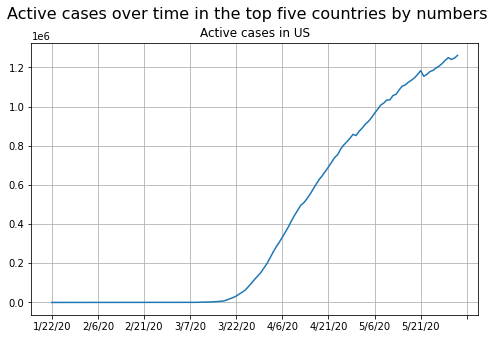

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(top_four_all["Date"],top_four_all[top_four[0] + ' active'])
ax.set_title('Active cases in {}'.format(top_four[0]))
ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.grid(True)

fig.suptitle('Active cases over time in the top five countries by numbers', fontsize=16)

plt.show()

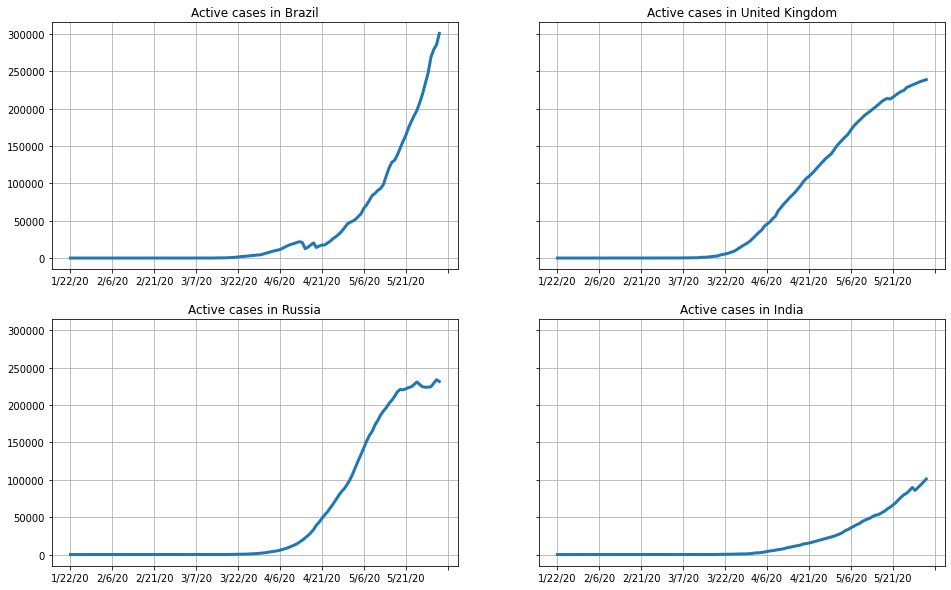

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(16,10), sharey = True)

def plot_top4(da,num,xcol, ycol, title):
    ax[num].plot(da[xcol],da[ycol], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[num].grid(True)
    
plot_top4(top_four_all, (0,0), "Date", top_four[1] + ' active', 'Active cases in {}'.format(top_four[1]))
plot_top4(top_four_all, (0,1), "Date", top_four[2] + ' active', 'Active cases in {}'.format(top_four[2]))
plot_top4(top_four_all, (1,0), "Date", top_four[3] + ' active', 'Active cases in {}'.format(top_four[3]))
plot_top4(top_four_all, (1,1), "Date", top_four[4] + ' active', 'Active cases in {}'.format(top_four[4]))

plt.show()

On 26.03, US has surpassed Italy in number of active cases and China in number of total positives. 
<br>US curve of active cases has grown dramatically since mid March. 
<br>Italy started a strong growth of cases around the carnival festivities in the third week of February whereas Germany's and Spain's curves of active cases started to go up at a fast pace around two weeks after. In Germany many of the initial cases were connected to people who went for a winter holiday in northern Italy in the third week of February.
<br> As of 05.04, the growth of the active cases curves in the top European countries is showing signs of slowing down.
<br>Question: Why did the curve in US take momentum in such a short timeframe in comparison to Italy, Germany and Spain? Might it be related to the lack of early contigency measures and lack of initial testing? 
<br>As in many of the countries with most active cases, the most dense and international cities are the ones worst hit by the outbreak. In US, the biggest hub of cases is located in NYC. 

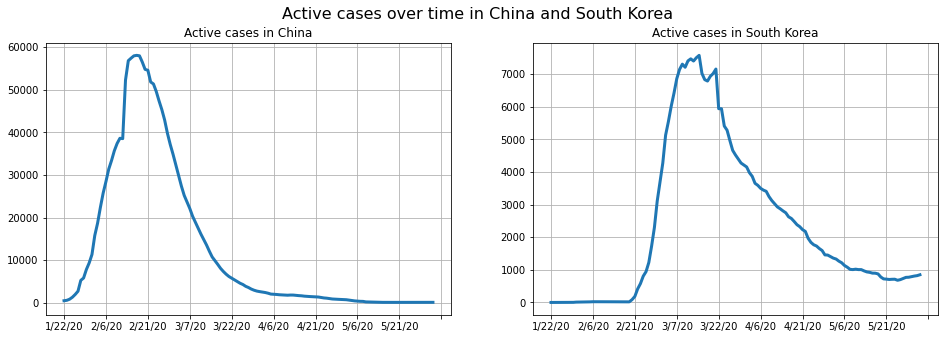

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (16,5))
plot_top4(top_four_all, 0, "Date", 'China active', 'Active cases in China')
plot_top4(top_four_all, 1, "Date", 'South Korea active', 'Active cases in South Korea')
fig.suptitle('Active cases over time in China and South Korea', fontsize = 16)

plt.show()

We compare the curves above with the one from China, the country with the first reported outbreak. It is worth mentioning that the official data provided by China has been questioned by the international community.
<br> We added also the graph from South Korea where the active cases are starting to drop since mif March.
<br> In both countries the peak of active cases shows in the graphs around a month since the curve started to increase at a fast pace. 
<br>Both countries took strict measures to content the spread of the virus including lockdowns of hotspots, social distancing, self-isolation and closing of public places and schools. In addition, in South Korea, a massive testing campaign was done to identify and traces cases in the earlier stages and limit the spread. 

## References
[1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf) Jennifer Beam Dowd, Valentina Rotondi, Liliana Andriano, David M. Brazel, Per Block, Xuejie Ding, Yan
Liu, Melinda C. Mills. 
  <br>Demographic science aids in understanding the spread and fatality
rates of COVID-19. March 15, 2020

[2](https://www.faz.net/aktuell/wissen/geist-soziales/coronavirus-pandemie-warum-ist-es-in-italien-so-schlimm-16693408.html) Andreas Rossmann. Warum ist es in Italien so schlimm? Frankfurter Allgemeine Zeiting. March 23, 2020.

[3](https://de.statista.com/infografik/21211/anzahl-der-durchgefuehrten-coronavirus-tests-je-1-mio-einwohner-in-laendern-weltweit/) Frauke Suhr. So oft wird auf COVID-19 getestet. May 4, 2020.

[4](https://de.statista.com/statistik/daten/studie/1103904/umfrage/corona-infektionen-covid-19-in-deutschland-nach-altersgruppe/) Corona-Infektionen (COVID-19) in Deutschland nach Altersgruppen. May 17, 2020.